In [154]:
import numpy as np
from scipy.optimize import curve_fit
from scipy.stats import chi2
from matplotlib import pyplot as plt
%matplotlib inline
def chiSq(modelparam, model, x, y, yerr):
    '''sum up all the square reduced residuals for use in chisquared'''
    return np.sum(((y-model(x, *modelparam))/yerr)**2) 
rhos = [997.38, 1026.6, 1055.8, 1084.7, 1113.0,
        1140.3, 1166.6, 1191.6] # kg/m^3
etas = [0.00093505, 0.0012808, 0.0018249, 0.0027285, 0.0043309,
        0.0074104, 0.013960, 0.029822] # Ns/m^-2
r = 0.007/2 # m

Instead of using a numerical or analytical solution instead fit a simple damped sine curve to the data and then analyse the fitting coefficients

In [155]:
def dampedSine(x, a, b, c, d, e):
    return a * np.exp(b*x) * np.sin(c*x+d) + e

Singular Analysis, treat all the data files as separate and different and plot the values for each of the 3 videos on the same graphs

In [156]:
def analyse(filename, plot=True, prnt=True, ax=None):
    q = np.genfromtxt(filename,delimiter='\t',skip_header=2).T
    t = q[0]
    y = q[2]
    # incase we need to skip the first few datapoints
    skip = 0
    y = y[skip:]
    t = t[skip:] - t[skip]
    yp = y[np.isfinite(y)]
    t = t[np.isfinite(y)]
    y = yp
    ### see comment in multi analyse about errors
    y_err = np.full(shape=y.shape, fill_value=0.001)
    P = curve_fit(dampedSine, t, y, sigma=y_err, absolute_sigma=True)
    if plot:
        if ax is None:
            ax = plt.figure()
        plt.scatter(t, y, label=f"{filename}")
        plt.plot(t, dampedSine(t, *P[0]), color="r", label="Decaying Sine Curve")
        plt.legend()
    if prnt:
        for e, a, b in zip("ABCDE", P[0], np.sqrt(np.diag(P[1]))):
            print(e, ":", a, "+/-", b)
        print()

    return np.array([P[0], np.sqrt(np.diag(P[1]))])

In [157]:
vals = []
for perc in range(0, 80, 10):
    v = []
    ax = plt.figure()
    for file in [f"{perc}%V1",f"{perc}%V2",f"{perc}%V3"]:
        ps = analyse(file, False, False, ax)
        v.append(ps)
    vals.append(v)
vals=np.array(vals)
conc = np.array([[x,x,x] for x in range(0, 80, 10)]).flatten()

# take all data sets, take all 3 videos,
# then the 0th for data and 1st for err,
# then 0,1,2,3,4 for appropriate variable
# then flatten into one list
# take absolute values for A and C as these can be negative for no real reason
# ie when A is negative C is negative to compensate => artifact of curvefitting
SingAs = abs(vals[:, :, 0, 0]).flatten()
SingAerr = vals[:, :, 1, 0].flatten()
SingBs = vals[:, :, 0, 1].flatten()
SingBerr = vals[:, :, 1, 1].flatten()
SingCs = abs(vals[:, :, 0, 2]).flatten()
SingCerr = vals[:, :, 1, 2].flatten()
SingDs = vals[:, :, 0, 3].flatten()
SingDerr = vals[:, :, 1, 3].flatten()
SingEs = vals[:, :, 0, 4].flatten()
SingEerr = vals[:, :, 1, 4].flatten()

def fitter(x, a, b, c):
    return a*x**2+b*x+c

def plotCoeff(x, y, yerr, title_="", ylabel_="", ax=None, residuals=True):
    if ax is None:
        fig = plt.figure()
    pfit, pcov = curve_fit(f=fitter, xdata=x, ydata=y, p0=(1,1,1), sigma=yerr, absolute_sigma=True)
    xs = np.linspace(0, x[-1])
    ys = fitter(xs, pfit[0], pfit[1], pfit[2])
    
    # main data and model plot
    ax1 = fig.add_axes((0, 0.2, 0.8, 0.8))
    ax1.errorbar(x=x, y=y, yerr=yerr, fmt="r.", capsize=5)
    ax1.plot(xs, ys, "b--")
    ax1.set_title("$A * exp(B*t) * sin(C*t+D) + E$, " + title_)
    ax1.set_xlabel("Conc by vol (%)")
    ax1.set_ylabel(ylabel_)

    if residuals:
        #residuals
        xs = x
        yres = y - fitter(xs, *pfit)
        ax2 = fig.add_axes((0, 0, 0.8, 0.2), sharex=ax1)
        ax2.errorbar(xs, yres, yerr, fmt="b.", capsize=5, )
        ax2.set_xlabel("Conc by vol (%)")
        ax2.set_ylabel("Residuals")

        #histogram
        ax3 = fig.add_axes((0.8, 0, 0.2, 0.2), sharey=ax2)
        ax3.hist(x=yres, bins=8, orientation="horizontal")

        chisqmin = chiSq(pfit, fitter, x, y, yerr)
        DoF = x.size - len((1,1,1))
        redchisqmin = chisqmin / DoF

        p_val = chi2.sf(chisqmin, DoF)

        return pfit, np.sqrt(np.diag(pcov)), redchisqmin, p_val
    else:
        return pfit, np.sqrt(np.diag(pcov))

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

(array([-4.40444264e-04,  8.11550259e-04,  9.58895120e+00]),
 array([8.96911329e-06, 4.02464708e-04, 3.62456740e-03]))

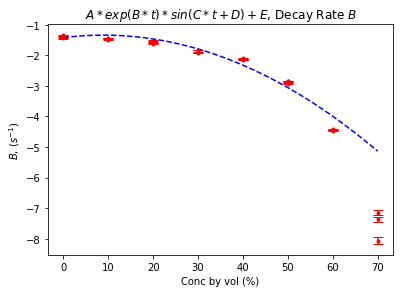

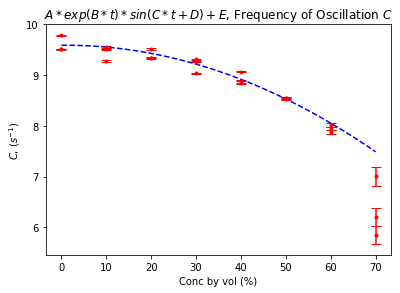

In [158]:
#plot As 
# function of Initial Depth, uninteresting for current experiment
#plotCoeff(conc, SingAs, SingAerr, "Maximum Amplitude $A$", "$A$, ($cm$)")

#plot Bs
# Decay Rate, interesting negative correlation
plotCoeff(conc, SingBs, SingBerr, "Decay Rate $B$", "$B$, ($s^{-1}$)", residuals=False)

#plot Cs
# Frequency of Oscillation, uninteresting seemingly constant
plotCoeff(conc, SingCs, SingCerr, "Frequency of Oscillation $C$", "$C$, ($s^{-1}$)", residuals=False)

#plot Ds
# Phase shift, uninteresting in all.
#plotCoeff(conc, SingDs, SingDerr, "Phase Shift $D$", "$D$, (radians)")

#Plot Es
# A shift of the axes, uninteresting
#plotCoeff(conc, SingEs, SingEerr, "Zero-point Shift $E$", "$E$, ($cm$)")

Multianalysis, combine each of the 3 videos into one data set which is then analysed.

Combine the 3 sets of data for each percentage into one set and analyse. This results in smaller errors and the fitting appears to be better. 70% is still a problem though this is mostly due to it not having an actual frequency as there are very few (if any) oscillations.

In [159]:
def multianalyse(filenames, plot=True, prnt=True, ax=None):
    ts = []
    ys = []
    for filename in filenames:
        q = np.genfromtxt(filename,delimiter='\t',skip_header=2).T
        t = q[0]
        y = q[2]
        # incase we need to skip data points,
        # less useful for large datasets 
        # or when using for many different files
        skip = 0
        y = y[skip:]*100 + 9 # m to cm
        t = t[skip:] - t[skip]
        ys.extend(y)
        ts.extend(t)
    y = np.array(ys)
    t = np.array(ts)
    yp = y[np.isfinite(y)]
    t = t[np.isfinite(y)]
    y = yp
    # sort t, sort y in same way
    way = t.argsort()
    t = t[way]
    y = y[way]
    # errors are currently quite ill defined
    ### could use a damped cosine curve for the error?
    y_err = np.full(shape=y.shape, fill_value=0.001)
    P = curve_fit(dampedSine, t, y, sigma=y_err, absolute_sigma=True)
    if plot:
        if ax is None:
            plt.figure()
        plt.scatter(t, y, label=f"{filename[:-2]}")
        plt.plot(t, dampedSine(t, *P[0]), color="r",)# label="Decaying Sine Curve")
        #plt.xlabel("time (s)")
        #plt.ylabel("Water level above bottom of straw (cm)")
        #plt.xlim(left=-0.1)
        plt.ylim(bottom=-0.5)
        plt.legend(loc="lower right")
    if prnt:
        for e, a, b in zip("ABCDE", P[0], np.sqrt(np.diag(P[1]))):
            print(e, ":", a, "+/-", b)
        print()

    return np.array([P[0], np.sqrt(np.diag(P[1]))])

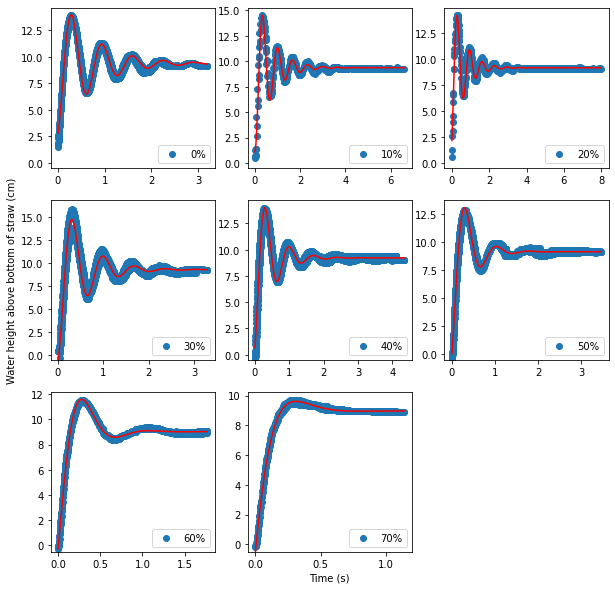

In [162]:
ax = plt.figure(figsize=(10,10))
# 1 2 3
# 4 5 6
# 7 8 9
pt = 1
vals = []
for perc in range(0, 80, 10):
    v = []
    plt.subplot(3,3,pt)
    if pt == 4:
        plt.ylabel("Water height above bottom of straw (cm)")
    if pt == 8:
        plt.xlabel("Time (s)")
    pt += 1
    ps = multianalyse([f"{perc}%V1",f"{perc}%V2",f"{perc}%V3"], True, False, ax=ax)
    v.append(ps)
    vals.append(v)

vals=np.array(vals)
conc = np.array([[x] for x in range(0, 80, 10)]).flatten()

# take all data sets, take the 0th element (3 videos combined into 1),
# then the 0th for data and 1st for err,
# then 0,1,2,3,4 for appropriate variable
# then flatten into one list
# take absolute values for A and C as these can be negative for no real reason
# ie when A is negative C is negative to compensate => artifact of curvefitting
MulAs = abs(vals[:, 0, 0, 0]).flatten()
MulAerr = vals[:, 0, 1, 0].flatten()
MulBs = vals[:, 0, 0, 1].flatten()
MulBerr = vals[:, 0, 1, 1].flatten()
MulCs = abs(vals[:, 0, 0, 2]).flatten()
MulCerr = vals[:, 0, 1, 2].flatten()
MulDs = vals[:, 0, 0, 3].flatten()
MulDerr = vals[:, 0, 1, 3].flatten()
MulEs = vals[:, 0, 0, 4].flatten()
MulEerr = vals[:, 0, 1, 4].flatten()


(array([-1.01643089e-03,  1.81713158e-02, -1.44058208e+00]), array([7.45798131e-08, 3.59479004e-06, 3.68396950e-05]))
(array([-9.10125575e-04,  1.40139100e-02, -1.43163824e+00]), array([7.77597332e-08, 3.69640677e-06, 3.68862048e-05]))
(array([-4.28246046e-04,  2.81887981e-04,  9.58086072e+00]), array([9.10791895e-08, 4.10571867e-06, 3.68416635e-05]))
(array([-4.08663770e-04, -4.64726325e-04,  9.58215542e+00]), array([9.25564582e-08, 4.15345319e-06, 3.68577371e-05]))


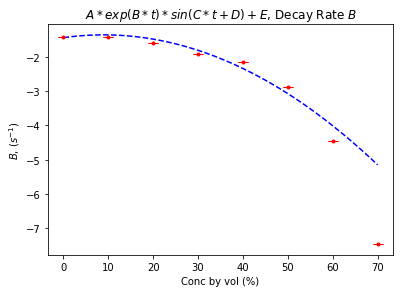

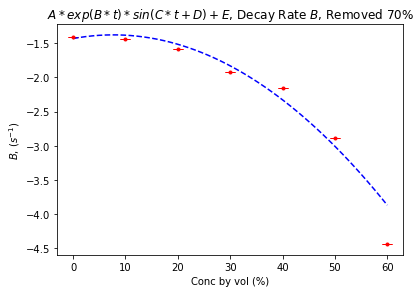

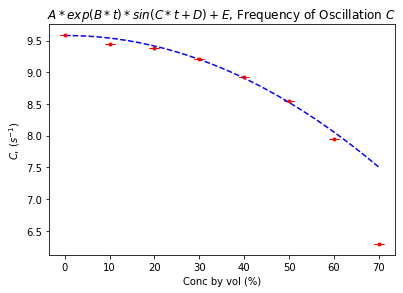

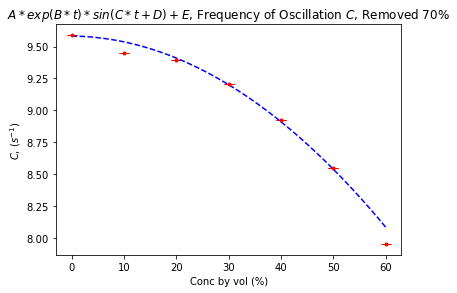

In [161]:
#Only interesting plots are B and C, others are variables to translate the model around to fit as seen in singular analysis
#plot Bs
# Decay Rate, interesting negative correlation
print(plotCoeff(conc, MulBs, MulBerr, "Decay Rate $B$", "$B$, ($s^{-1}$)", residuals=False))
print(plotCoeff(conc[:-1], MulBs[:-1], MulBerr[:-1], "Decay Rate $B$, Removed 70%", "$B$, ($s^{-1}$)", residuals=False))

#plot Cs
# Frequency of Oscillation, uninteresting seemingly constant
print(plotCoeff(conc, MulCs, MulCerr, "Frequency of Oscillation $C$", "$C$, ($s^{-1}$)", residuals=False))
print(plotCoeff(conc[:-1], MulCs[:-1], MulCerr[:-1], "Frequency of Oscillation $C$, Removed 70%", "$C$, ($s^{-1}$)", residuals=False))